<a href="https://colab.research.google.com/github/esthel7/ai/blob/master/predict_epidemic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#사용할 라이브러리

from keras.models import Sequential #sequential 모델 불러오기
from keras.layers import SimpleRNN, Dense #RNN은 순환 신경망, simpleRNN은 간단한 순환 신경망
#순환 신경망은 이전의 연속된 데이터 사용하여 이후의 값 예측
#Dense는 각 레이어에서의 뉴런의 수

from sklearn.preprocessing import MinMaxScaler #MinMaxScale는 정규화함수, sklearn 라이브러리 속에 있음
from sklearn.metrics import mean_squared_error #mean_squared_error는 정확도 계산 위해 오차값 계산
from sklearn.model_selection import train_test_split #데이터를 학습데이터와 검증데이터로 나눔(성능측정위함)
import math #수학 계산
import numpy as np #수학 계산 라이브러리를 np 이름으로 불러옴
import matplotlib.pyplot as plt #그래프 그리기 위함
from pandas import read_csv #pandas는 데이터 잘 처리하도록하는 라이브러리, csv 파일 불러옴

In [2]:
#깃허브 데이터 가져오기

!git clone https://github.com/yhlee1627/deeplearning.git #mnist는 keras 안의 데이터, git은 외부데이터
dataframe=read_csv('/content/deeplearning/corona_daily.csv',usecols=[3],engine='python',skipfooter=3)
#해당 git의 deeplearning파트에서 corona_daily.csv 불러오기
#usecols는 해당 열만 불러오는 것으로, 4번째 열만 사용

print(dataframe)
dataset=dataframe.values #데이터만 사용
datatset=dataset.astype('float32') #데이터 정규화(0~1로 변환 = 성능 향상) 위해 실수로 변환

Cloning into 'deeplearning'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
     Confirmed
0           24
1           24
2           27
3           27
4           28
..         ...
107      11190
108      11206
109      11225
110      11265
111      11344

[112 rows x 1 columns]


In [3]:
#데이터 정규화 및 분류

scaler=MinMaxScaler(feature_range=(0,1)) #데이터를 0~1사이로 정규화하기 위한 함수
Dataset=scaler.fit_transform(dataset) #데이터 정규화
train_data, test_data=train_test_split(Dataset, test_size=0.2, shuffle=False) 
#학습 데이터, 테스트 데이터로 나눔. 테스트 데이터를 20%. 성능 정확히 측정하기 위함
#shuffle은 무작위 추출. 코로나 데이터를 예측하기 위함으로 무작위 추출이 아닌 앞선 데이터만 학습 데이터로

print(len(train_data), len(test_data))

89 23


In [4]:
#데이터 형태 변경하기

def create_dataset(dataset, look_back): #원래의 데이터, 연속되는 데이터의 개수
  x_data=[]
  y_data=[]
  for i in range(len(dataset)-look_back):
    data=dataset[i:(i+look_back),0]
    x_data.append(data)
    y_data.append(dataset[i+look_back,0])
  return np.array(x_data), np.array(y_data) #배열로 변환

In [5]:
#입력 데이터 생성하기

look_back=3 
#며칠동안 연속된 데이터를 사용할 지 지정
#오래된 날짜를 한번에 학습할 경우 오류 생길 가능성 많음, 3일마다 한번씩 예측해서 학습시키기
#1~3일로 4일 예측, 2~4일로 5일 예측 ...

x_train, y_train=create_dataset(train_data, look_back)
x_test, y_test=create_dataset(test_data, look_back)
print(x_train.shape, y_train.shape) #x_train은 3개씩 86줄
print(x_test.shape, y_test.shape) #x_test는 3개씩  20줄

(86, 3) (86,)
(20, 3) (20,)


In [6]:
#인공지능 모델에 넣어줄 형태로 변환하기

X_train=np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1])) #형태 바꿔주는 reshape 함수
#원래 데이터인 x_train(86줄)을 1*3(x_train.shape[1])로 만들기 (2차원에서 3차원으로)

X_test=np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(X_train.shape) #1*3으로 구성된 데이터가 86개
print(X_test.shape) #1*3으로 구성된 데이터가 20개

(86, 1, 3)
(20, 1, 3)


In [7]:
#인공지능 모델

model=Sequential() #순환신경망은 레이어들이 선형으로 연결된 모습이라 sequential로 설정
model.add(SimpleRNN(3, input_shape=(1, look_back))) #뉴런의 수는 3개, input data로 1*(look_back)값 넣기
model.add(Dense(1, activation="linear")) #최종 예측값은 연속된 데이터 이후 값&1개이므로 1개 노드로 구성
model.compile(loss='mse', optimizer='adam') #계산방법 결정, 손실함수는 mse사용(평균 제곱 오차, 음수계산때문)
#optimizer는 오차 줄이기, adam 사용

model.summary() #모델이 어떻게 구성되었는지 살펴보기

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 21        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [8]:
#모델 학습시키기

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)
#입력데이터, 출력데이터, 학습반복수, 한번에 학습시킬 데이터 양
#verbose 0은 아무런 표시 하지 않음, 1은 진행 사항 알려줌, 2는 학습 결과 알려줌 

Epoch 1/100
86/86 [==============================] - 1s 2ms/step - loss: 0.7673
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4228
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.1997
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0942
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 10/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 11/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 12/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 13/100
86/86 [=================

In [9]:
#데이터 예측하기

trainPredict=model.predict(X_train) #모델이 결괏값 생성하는 predict 함수, 반환값은 0~1 사이
testPredict=model.predict(X_test)
TrainPredict=scaler.inverse_transform(trainPredict) #0~1 사이의 값을 실제 데이터로 변환 - scaler 함수
Y_train=scaler.inverse_transform([y_train])
TestPredict=scaler.inverse_transform(testPredict)
Y_test=scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 20ms/step


In [13]:
#모델의 정확도 살펴보기

trainScore=math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:,0])) #sqrt는 루트
#mead_squared_error는 정확도 계산 위해 오차값 계산 (실제값과 예측값 비교)
#Y_train[0]은 실제 정답값 전체

print('Train Score: %.2f RMSE' %(trainScore)) #학습데이터의 오차값
testScore=math.sqrt(mean_squared_error(Y_test[0], TestPredict[:,0]))
print('Test Score: %.2f RMSE' %(testScore)) #테스트데이터의 오차값

Train Score: 196.96 RMSE
Test Score: 323.84 RMSE


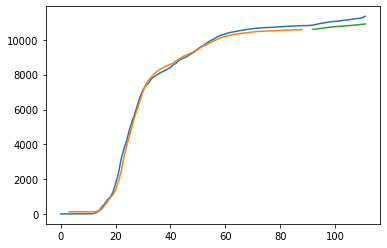

In [48]:
#결과를 그래프로 확인

trainPredictPlot=np.empty_like(dataset, dtype='float32') #dataset(float)과 동일한 크기의 빈 배열 만들기
trainPredictPlot[:,:]=np.nan #nan을 써서 값 없음, 그래프 그릴 도화지 깨끗하게 만들기 위함
trainPredictPlot[look_back:len(TrainPredict)+look_back, :]=TrainPredict
#1~3일차를 통해 4일차 예측한게 첫 데이터이므로, look_back만큼 더한 값으로 시작

testPredictPlot=np.empty_like(dataset, dtype='float32')
testPredictPlot[:,:]=np.nan
testPredictPlot[len(TrainPredict)+(look_back)*2:len(dataset),:]=TestPredict
#처음 3일(look_back) 후 trainPredict, 3일 후 testPrecit 이므로 look_back 2번 곲해준 값 더하기

plt.plot(dataset) #그래프로 그리기
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() #화면에 나타내기

#파란선은 실제 데이터, 주황색은 학습 데이터, 초록색은 예측 데이터